<a href="https://colab.research.google.com/github/gonzaq94/NER-LLM-classification/blob/main/fine_tune_BERT_doc_level_and_NER_annots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import comet_ml
import comet_llm
import os
import gdown
from datasets import load_dataset, concatenate_datasets
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from openai import OpenAI
import seaborn as sns
import numpy as np
from torch.nn import CrossEntropyLoss, MSELoss

# Data preparation

### Doc-labels-balanced data


In [ ]:
from datasets import load_from_disk

loaded_train_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k_strat")
loaded_valid_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented_1k_strat")
loaded_test_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_test_augmented")

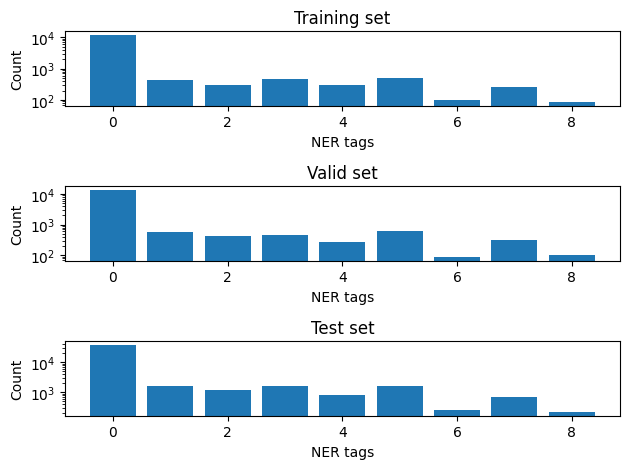

In [ ]:
from collections import Counter

# train set
plt.subplot(3,1,1)
histogram = Counter(list(chain.from_iterable(loaded_train_dataset['ner_tags'])))
sorted_histogram = dict(sorted(histogram.items(), key=lambda item: item[0], reverse=False))
plt.bar(sorted_histogram.keys(), sorted_histogram.values())
plt.xlabel("NER tags")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Training set")

# train set
plt.subplot(3,1,2)
histogram = Counter(list(chain.from_iterable(loaded_valid_dataset['ner_tags'])))
sorted_histogram = dict(sorted(histogram.items(), key=lambda item: item[0], reverse=False))
plt.bar(sorted_histogram.keys(), sorted_histogram.values())
plt.xlabel("NER tags")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Valid set")

# train set
plt.subplot(3,1,3)
histogram = Counter(list(chain.from_iterable(loaded_test_dataset['ner_tags'])))
sorted_histogram = dict(sorted(histogram.items(), key=lambda item: item[0], reverse=False))
plt.bar(sorted_histogram.keys(), sorted_histogram.values())
plt.xlabel("NER tags")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Test set")

plt.tight_layout()
plt.show()

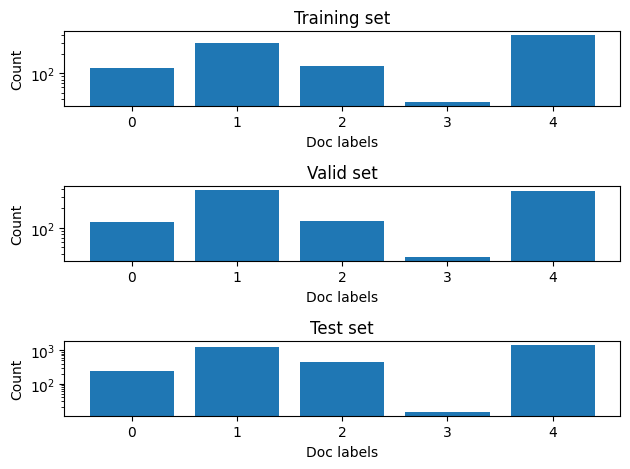

In [ ]:
from collections import Counter

# train set
plt.subplot(3,1,1)
histogram = Counter(loaded_train_dataset['doc_labels'])
sorted_histogram = dict(sorted(histogram.items(), key=lambda item: item[0], reverse=False))
plt.bar(sorted_histogram.keys(), sorted_histogram.values())
plt.xlabel("Doc labels")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Training set")

# train set
plt.subplot(3,1,2)
histogram = Counter(loaded_valid_dataset['doc_labels'])
sorted_histogram = dict(sorted(histogram.items(), key=lambda item: item[0], reverse=False))
plt.bar(sorted_histogram.keys(), sorted_histogram.values())
plt.xlabel("Doc labels")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Valid set")

# train set
plt.subplot(3,1,3)
histogram = Counter(loaded_test_dataset['doc_labels'])
sorted_histogram = dict(sorted(histogram.items(), key=lambda item: item[0], reverse=False))
plt.bar(sorted_histogram.keys(), sorted_histogram.values())
plt.xlabel("Doc labels")
plt.ylabel("Count")
plt.yscale("log")
plt.title("Test set")

plt.tight_layout()
plt.show()

# Dataset creation

In [ ]:
# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_WORKSPACE"] = "gonzaq94"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-doc_level_and_NER_annots-strat_data"

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

class SeqTokenDataset(Dataset):
    def __init__(self, texts, token_labels, sequence_labels, tokenizer, max_length):
        self.texts = texts
        self.token_labels = token_labels
        self.sequence_labels = sequence_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        token_labels = self.token_labels[idx]
        sequence_labels = self.sequence_labels[idx]

        tokens = []
        labels_per_token = []
        attention_masks = []

        # first add the CLS special token
        tokens.append(self.tokenizer.cls_token_id)
        labels_per_token.append(-100)
        attention_masks.append(0)

        # tokenize each word independantly
        for word, label in zip(text, token_labels):
          # Tokenize each word
          word_encoding = self.tokenizer(
              word,
              add_special_tokens=False,
              max_length=self.max_length,
              truncation=True,
              return_tensors="pt"
          )

          tokens.extend(word_encoding['input_ids'][0].tolist())
          attention_masks.extend(word_encoding['attention_mask'][0].tolist())
          labels_per_token.extend([label] * len(word_encoding['input_ids'][0]))

        # finally, add the SEP special token
        tokens.append(self.tokenizer.sep_token_id)
        labels_per_token.append(-100)
        attention_masks.append(0)

        # add padding
        padding_len = self.max_length - len(tokens)
        tokens += [0] * padding_len
        attention_masks += [0] * padding_len
        labels_per_token += [-100] * padding_len

        return {
            'input_ids': torch.tensor(tokens).flatten(),
            'attention_mask': torch.tensor(attention_masks).flatten(),
            'token_labels': torch.tensor(labels_per_token).flatten(),
            'sequence_labels': torch.tensor(sequence_labels).flatten()
        }

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_custom_dataset = SeqTokenDataset(
    texts=loaded_train_dataset['tokens'],
    token_labels=loaded_train_dataset['ner_tags'],
    sequence_labels=loaded_train_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

valid_custom_dataset = SeqTokenDataset(
    texts=loaded_valid_dataset['tokens'],
    token_labels=loaded_valid_dataset['ner_tags'],
    sequence_labels=loaded_valid_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

test_custom_dataset = SeqTokenDataset(
    texts=loaded_test_dataset['tokens'],
    token_labels=loaded_test_dataset['ner_tags'],
    sequence_labels=loaded_test_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

# Define Sequence and token classification model

In [ ]:
from transformers import BertPreTrainedModel, BertModel, BertConfig
import torch.nn as nn
from safetensors.torch import load_file

class CustomBertConfig(BertConfig):
    def __init__(self, num_token_labels = 10, num_sequence_labels = 2, seq_loss_weight = 1, **kwargs):
        super().__init__(**kwargs)
        self.num_token_labels = num_token_labels
        self.num_sequence_labels = num_sequence_labels
        self.seq_loss_weight = seq_loss_weight

class BertForSequenceAndTokenClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels_sequence = config.num_sequence_labels
        self.num_labels_token = config.num_token_labels
        self.seq_loss_weight = config.seq_loss_weight

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.token_classifier = nn.Linear(config.hidden_size, self.num_labels_token)
        self.sequence_classifier = nn.Linear(config.hidden_size, self.num_labels_sequence)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        token_labels=None,
        sequence_labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        # token classification
        token_representation = self.dropout(outputs.last_hidden_state)
        token_logits = self.token_classifier(token_representation)

        # sequence classification
        sequence_representation = self.dropout(outputs.pooler_output)
        sequence_logits = self.sequence_classifier(sequence_representation)

        outputs = (token_logits,) + (sequence_logits,) + outputs[2:]  # add hidden states and attention if they are here

        # token loss
        if token_labels is not None or sequence_labels is not None:
          if token_labels is not None:
              loss_fct = CrossEntropyLoss()

              if attention_mask is not None:
                  active_token_loss = attention_mask.view(-1) == 1
                  active_token_logits = token_logits.view(-1, self.num_labels_token)
                  active_labels_token = torch.where(
                      active_token_loss, token_labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(token_labels)
                  )
                  token_loss = loss_fct(active_token_logits, active_labels_token)
              else:
                  token_loss = loss_fct(token_logits.view(-1, self.num_labels_token), token_labels.view(-1))
          else:
            token_loss = 0.0

          # sequence loss
          if sequence_labels is not None:
            if self.num_labels_sequence == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                sequence_loss = loss_fct(sequence_logits.view(-1), sequence_labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                sequence_loss = loss_fct(sequence_logits.view(-1, self.num_labels_sequence), sequence_labels.view(-1))
          else:
            sequence_loss = 0.0

          total_loss = (1 - self.seq_loss_weight) * token_loss + self.seq_loss_weight * sequence_loss

          outputs = (total_loss,) + outputs

        return outputs  # (loss), token_logits, sequence_logits, (hidden_states), (attentions)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, num_token_labels, num_sequence_labels, seq_loss_weight=1, *args, **kwargs):

        # load config
        config = CustomBertConfig.from_pretrained(pretrained_model_name_or_path, *args, **kwargs)
        config.num_token_labels = num_token_labels
        config.num_sequence_labels = num_sequence_labels
        config.seq_loss_weight = seq_loss_weight

        # create model instance
        model = cls(config)

        # load BERT pre-trained weights
        #model.bert = BertModel.from_pretrained(pretrained_model_name_or_path)

        # Load the model weights from a .safetensors file
        model_weights = load_file(pretrained_model_name_or_path + "/model.safetensors")
        model.load_state_dict(model_weights, strict=False)


        return model



In [ ]:
def compute_metrics(p):

    predictions, labels = p
    ner_predictions, doc_predictions = predictions
    ner_labels, doc_labels = labels

    # NER metrics
    ner_predictions = ner_predictions.argmax(-1)  # Get the predicted class indices
    true_ner_predictions = [p for (p, l) in zip(ner_predictions.flatten(), ner_labels.flatten()) if l != -100]
    true_ner_labels = [l for l in ner_labels.flatten() if l != -100]

    ner_precision, ner_recall, ner_f1, _ = precision_recall_fscore_support(true_ner_labels, true_ner_predictions, average='weighted', zero_division=1 )
    ner_acc = accuracy_score(true_ner_labels, true_ner_predictions)

    # doc-level metrics
    doc_predictions = doc_predictions.argmax(-1)  # Get the predicted class indices
    doc_precision, doc_recall, doc_f1, _ = precision_recall_fscore_support(doc_labels, doc_predictions, average='weighted', zero_division=1 )
    doc_acc = accuracy_score(doc_labels, doc_predictions)

    return {
        'ner_accuracy': ner_acc,
        'ner_f1': ner_f1,
        'ner_precision': ner_precision,
        'ner_recall': ner_recall,
        'doc_accuracy': doc_acc,
        'doc_f1': doc_f1,
        'doc_precision': doc_precision,
        'doc_recall': doc_recall,
        'f1': (doc_f1 + ner_f1) / 2,
    }

In [ ]:
class_freqs = torch.tensor(np.histogram(loaded_train_dataset['doc_labels'], bins=5)[0]).to("cpu")
class_weights = 1.0 / class_freqs
class_weights = class_weights / class_weights.sum()
print(class_weights, class_freqs)

tensor([0.1638, 0.0662, 0.1502, 0.5709, 0.0490]) tensor([122, 302, 133,  35, 408])


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# weighted loss
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
      labels = inputs.get("labels")
      outputs = model(**inputs)
      logits = outputs.get("logits")

      loss_fct = CrossEntropyLoss(weight=class_weights)
      loss = loss_fct(logits.view(-1, len(class_weights)), labels.view(-1))

      return (loss, outputs) if return_outputs else loss


# weighted data loader
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(class_weights), replacement=True)

def torch_weighted_data_collator(features):

    # Sample features with weights according to their label
    labels = [f["label"] for f in features]
    weights = [class_weights[label] for label in labels]
    total_weight = sum(weights)
    probabilities = [weight / total_weight for weight in weights]

    # Sample with probabilities
    features = random.choices(features, weights=probabilities, k=len(features))

    batch = {}

    # Convert features to tensors
    for k in features[0].keys():
        if k == 'label':
            newk = 'labels'
        else:
            newk = k
        if isinstance(features[0][k], torch.Tensor):
            batch[newk] = torch.stack([f[k] for f in features])  # Use stack for tensors
        else:
            batch[newk] = torch.tensor([f[k] for f in features])  # Convert to tensor

    return batch

def torch_default_data_collator(features):

    first = features[0]
    batch = {}

    # Special handling for labels.
    # Ensure that tensor is created with the correct type
    # (it should be automatically the case, but let's make sure of it.)
    if "label" in first and first["label"] is not None:
        label = first["label"].item() if isinstance(first["label"], torch.Tensor) else first["label"]
        dtype = torch.long if isinstance(label, int) else torch.float
        batch["labels"] = torch.tensor([f["label"] for f in features], dtype=dtype)
    elif "label_ids" in first and first["label_ids"] is not None:
        if isinstance(first["label_ids"], torch.Tensor):
            batch["labels"] = torch.stack([f["label_ids"] for f in features])
        else:
            dtype = torch.long if isinstance(first["label_ids"][0], int) else torch.float
            batch["labels"] = torch.tensor([f["label_ids"] for f in features], dtype=dtype)

    # Handling of all other possible keys.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in first.items():
        if k not in ("label", "label_ids") and v is not None and not isinstance(v, str):
            if isinstance(v, torch.Tensor):
                batch[k] = torch.stack([f[k] for f in features])
            elif isinstance(v, np.ndarray):
                batch[k] = torch.from_numpy(np.stack([f[k] for f in features]))
            else:
                batch[k] = torch.tensor([f[k] for f in features])

    return batch

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}
ner_label_dct = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
SEQ_LOSS_WEIGHT = 1.0

model_name = 'bert-base-uncased'
model = BertForSequenceAndTokenClassification.from_pretrained(model_name,
                                                           num_sequence_labels=len(doc_label_dct),
                                                           num_token_labels=len(ner_label_dct),
                                                           seq_loss_weight=SEQ_LOSS_WEIGHT,
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)

if SEQ_LOSS_WEIGHT == 0.0:
  metric_best_model = 'ner_f1'
if SEQ_LOSS_WEIGHT == 1.0:
  metric_best_model = 'doc_f1'
else:
  metric_best_model = 'f1'


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from transformers.integrations import CometCallback

EPOCHS = 15
BATCH_SIZE = 24

experiment = comet_ml.Experiment(api_key=os.getenv("COMET_API_KEY"), project_name=os.getenv("COMET_PROJECT_NAME"), workspace=os.getenv("COMET_WORKSPACE"))

# Define a custom callback to ensure experiment.end() is called
class CustomCometCallback(CometCallback):

  def __init__(self, experiment):
      super().__init__()
      self._experiment = experiment

# define comet experiment
experiment = comet_ml.Experiment(
  api_key=os.getenv("COMET_API_KEY"),
  project_name=os.getenv("COMET_PROJECT_NAME"),
  workspace=os.getenv("COMET_WORKSPACE"))

experiment.set_name(f"only sequence loss")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_best_model,
    greater_is_better=True,
    save_total_limit=1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=16,
    warmup_steps=int((len(train_custom_dataset) / BATCH_SIZE)*EPOCHS / 10), #warmup set to 10 percent of total iterations
    learning_rate=2e-5,
    #lr_scheduler_type="cosine",
    weight_decay=0.01,
    logging_dir=None,
    dataloader_drop_last=False,
    fp16=True, # mixed precision
    report_to=["comet_ml"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=valid_custom_dataset,
    callbacks=[CustomCometCallback(experiment=experiment)],
    compute_metrics=compute_metrics,
    #compute_loss_func=compute_loss,
    #data_collator=torch_weighted_data_collator
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gonzaq94/ner-classif-bert-doc-level-and-ner-annots-strat-data/2ed16149de3b4cf2a9939c9c830fc8ba

COMET WARNING: Not all initial data has been logged for experiment 2ed16149de3b4cf2a9939c9c830fc8ba, call Experiment.end() to ensure that all data to have been logged
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : panicky

In [ ]:
trainer.train()

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET INFO: An experiment with the same configuration options is already running and will be reused.


Epoch,Training Loss,Validation Loss,Ner Accuracy,Ner F1,Ner Precision,Ner Recall,Doc Accuracy,Doc F1,Doc Precision,Doc Recall,F1
1,1.441000,1.259776,0.030281,0.008720,0.798293,0.030281,0.395146,0.265799,0.597683,0.395146,0.137259
2,1.096400,0.843628,0.025877,0.008250,0.794668,0.025877,0.709709,0.689104,0.737971,0.709709,0.348677
3,0.662300,0.558323,0.031023,0.018537,0.731357,0.031023,0.801942,0.788751,0.810358,0.801942,0.403644


## Log and register model in Comet

In [ ]:
registered_model_name = "ner_classif-bert-doc_level_and_NER_annots-strat_data-only_token"
experiment.log_model(registered_model_name, trainer.state.best_model_checkpoint)
experiment.register_model(registered_model_name)

In [ ]:
trainer.state.best_model_checkpoint

'./results/checkpoint-546'

In [ ]:
!ls ./results/checkpoint-546

config.json	   optimizer.pt   scheduler.pt	      training_args.bin
model.safetensors  rng_state.pth  trainer_state.json


# Evaluate best model

In [ ]:
def plot_confusion_matrix(cm, class_names, title='Normalized confusion Matrix'):

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def compute_metrics_eval_ner_and_doc(p):

    predictions, labels = p
    ner_predictions, doc_predictions = predictions
    ner_labels, doc_labels = labels

    # NER metrics
    ner_predictions = ner_predictions.argmax(-1)  # Get the predicted class indices
    true_ner_predictions = [p for (p, l) in zip(ner_predictions.flatten(), ner_labels.flatten()) if l != -100]
    true_ner_labels = [l for l in ner_labels.flatten() if l != -100]

    ner_precision, ner_recall, ner_f1, _ = precision_recall_fscore_support(true_ner_labels, true_ner_predictions, average='weighted', zero_division=1 )
    ner_acc = accuracy_score(true_ner_labels, true_ner_predictions)

    # doc-level metrics
    doc_predictions = doc_predictions.argmax(-1)  # Get the predicted class indices
    doc_precision, doc_recall, doc_f1, _ = precision_recall_fscore_support(doc_labels, doc_predictions, average='weighted', zero_division=1 )
    doc_acc = accuracy_score(doc_labels, doc_predictions)

    # Calculate confusion matrices
    ner_conf_matrix = confusion_matrix(true_ner_labels, true_ner_predictions, normalize='true')
    doc_conf_matrix = confusion_matrix(doc_labels, doc_predictions, normalize='true')

    return {
        'ner_accuracy': ner_acc,
        'ner_f1': ner_f1,
        'ner_precision': ner_precision,
        'ner_recall': ner_recall,
        'doc_accuracy': doc_acc,
        'doc_f1': doc_f1,
        'doc_precision': doc_precision,
        'doc_recall': doc_recall,
        'f1': (doc_f1 + ner_f1) / 2,
        'ner_confusion_matrix': ner_conf_matrix,
        'doc_confusion_matrix': doc_conf_matrix
    }

eval_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=16,
    report_to=[]
)


class Evaluator:
    def __init__(self, model, tokenizer, compute_metrics):
        self.model = model
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def evaluate(self, eval_dataset, batch_size=16):
        trainer = Trainer(
            model=self.model,
            args=training_args,
            compute_metrics=self.compute_metrics,
            eval_dataset=eval_dataset,
        )
        return trainer.evaluate()

### NER & Doc classification

In [ ]:
from comet_ml import API

api = API(api_key=os.getenv("COMET_API_KEY"))

# model name
model_name = "ner_classif-bert-doc_level_and_NER_annots-strat_data"

#get the Model object
model_doc_and_ner = api.get_model(workspace=os.getenv("COMET_WORKSPACE"), model_name=model_name)

# Download a Registry Model:
model_doc_and_ner.download("1.0.0", "./deploy", expand=True)

COMET INFO: Remote Model 'gonzaq94/ner_classif-bert-doc_level_and_NER_annots-strat_data:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 7 file(s), remaining 1.22 GB/1.22 GB
COMET WARNING: File './deploy/checkpoint-546/trainer_state.json' has been overwritten by asset 'bc48811f6fb7409bbfb53add750192db' of remote model
COMET WARNING: File './deploy/checkpoint-546/config.json' has been overwritten by asset '1e0fc697b0cf4bd4a2cca6cb7a107cf4' of remote model
COMET WARNING: File './deploy/checkpoint-546/training_args.bin' has been overwritten by asset 'c7475d32a1604be0a40cd6023da226cb' of remote model
COMET WARNING: File './deploy/checkpoint-546/scheduler.pt' has been overwritten by asset 'cb69c71ce5bb4257a7cf1256d4361e8b' of remote model
COMET WARNING: File './deploy/checkpoint-546/rng_state.pth' has been overwritten by asset 'd35daa9f92a74ca2be1f1db50a67b1c7' of remote model
COMET WARNING: File './deploy/checkpoint-546/optimizer.pt' has been overwritten by as

In [ ]:
model_doc_ner = BertForSequenceAndTokenClassification.from_pretrained("./deploy/checkpoint-546",
                                                           num_sequence_labels=len(doc_label_dct),
                                                           num_token_labels=len(ner_label_dct),
                                                           seq_loss_weight=0.5,
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)


In [ ]:
!ls ./deploy/checkpoint-546

config.json	   optimizer.pt   scheduler.pt	      training_args.bin
model.safetensors  rng_state.pth  trainer_state.json


In [ ]:
#loaded_test_dataset = loaded_test_dataset.shuffle().select(range(100))
test_custom_dataset = SeqTokenDataset(
    texts=loaded_test_dataset['tokens'],
    token_labels=loaded_test_dataset['ner_tags'],
    sequence_labels=loaded_test_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

In [ ]:
evaluator_ner_and_doc = Evaluator(model_doc_ner, tokenizer, compute_metrics_eval_ner_and_doc)

In [ ]:
eval_results = evaluator_ner_and_doc.evaluate(test_custom_dataset)

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET WARNING: Cannot safely convert array([[7.69874477e-01, 1.25523013e-02, 1.67364017e-02, 0.00000000e+00,
        2.00836820e-01],
       [1.56372166e-03, 9.31196247e-01, 1.56372166e-03, 0.00000000e+00,
        6.56763096e-02],
       [5.70175439e-02, 3.28947368e-02, 7.78508772e-01, 2.19298246e-03,
        1.29385965e-01],
       [7.14285714e-02, 0.00000000e+00, 2.14285714e-01, 5.71428571e-01,
        1.42857143e-01],
       [4.43686007e-02, 1.95904437e-01, 4.77815700e-02, 6.82593857e-04,
        7.11262799e-01]]) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET WARNING: Cannot safely convert array([[9.80871671e-01, 1.47479639e-03, 2.42130751e-04, 7.63812459e-03,
        3.23574730e-03, 2.04710544e-03, 6.60356593e-05, 4.13823465e-03,
        2.86154523e-04],
       [1.28771155e-02, 8.67917586e-01, 4.01030169e-02, 6.2545989

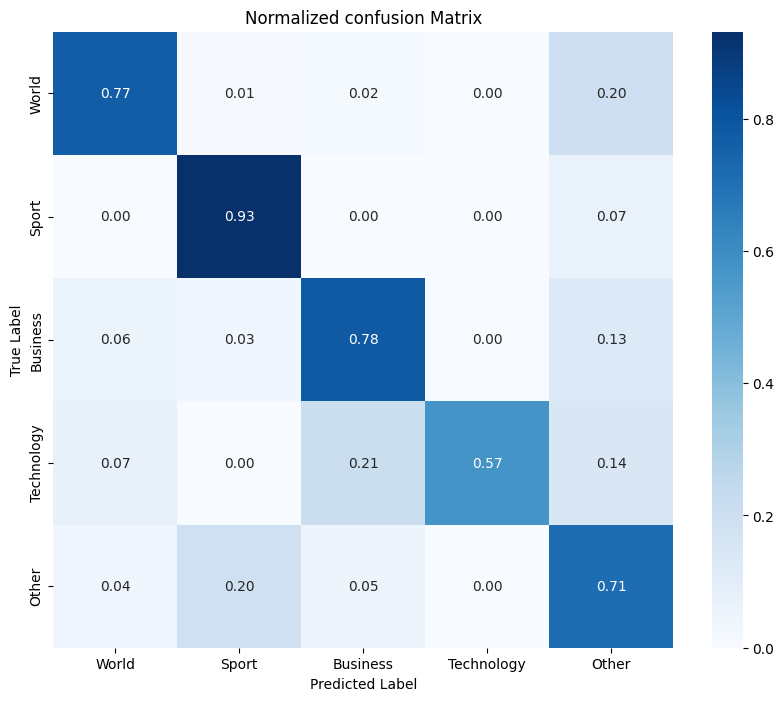

In [ ]:
class_names = [k for k, v in doc_label_dct.items()]
plot_confusion_matrix(eval_results['eval_doc_confusion_matrix'], class_names)

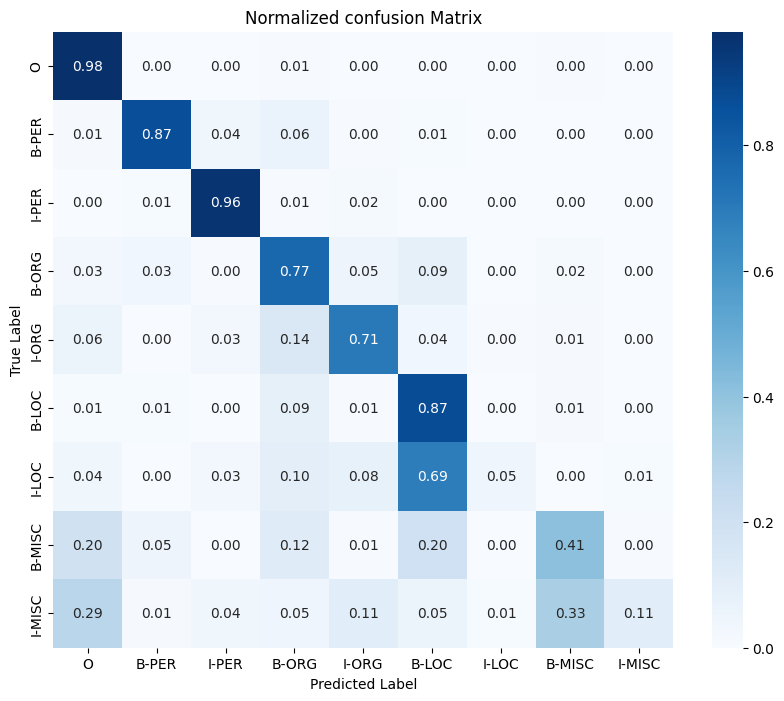

In [ ]:
class_names = [k for k, v in ner_label_dct.items()]
plot_confusion_matrix(eval_results['eval_ner_confusion_matrix'], class_names)

In [ ]:
for key, value in eval_results.items():
  if key != 'eval_ner_confusion_matrix' and key != 'eval_doc_confusion_matrix':
    print(f"{key}: {value}")

eval_loss: 0.5399687886238098
eval_model_preparation_time: 0.0099
eval_ner_accuracy: 0.9388509080864581
eval_ner_f1: 0.936749515718783
eval_ner_precision: 0.9388448943160301
eval_ner_recall: 0.9388509080864581
eval_doc_accuracy: 0.8050970170865913
eval_doc_f1: 0.8027389069712365
eval_doc_precision: 0.8099277244098328
eval_doc_recall: 0.8050970170865913
eval_f1: 0.8697442113450098
eval_runtime: 3397.2586
eval_samples_per_second: 1.016
eval_steps_per_second: 0.064


### Doc (sequence) classification

In [ ]:
from comet_ml import API
from google.colab import userdata


api = API(api_key=userdata.get('COMET_API_KEY'))

# model name
model_name = "ner_classif-bert-doc_level_and_NER_annots-strat_data-only_seq"

#get the Model object
model_doc_and_ner = api.get_model(workspace=userdata.get('COMET_WORKSPACE'), model_name=model_name)

# Download a Registry Model:
model_doc_and_ner.download("1.0.0", "./deploy/doc", expand=True)

CometRestApiException: GET https://www.comet.com/api/rest/v2/registry-model/compact-details?workspaceName=gonzaq94&modelName=ner_classif-bert-doc_level_and_NER_annots-strat_data-only_seq failed with status code 400: No such registry model

In [ ]:
model_doc = BertForSequenceAndTokenClassification.from_pretrained("./deploy/checkpoint-546",
                                                           num_sequence_labels=len(doc_label_dct),
                                                           num_token_labels=len(ner_label_dct),
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)


In [ ]:
evaluator_doc = Evaluator(model_doc, tokenizer, compute_metrics_eval_ner_and_doc)
eval_results = evaluator_doc.evaluate(test_custom_dataset)

### NER (token) classification

In [ ]:
from comet_ml import API

api = API(api_key=userdata.get('COMET_API_KEY'))

# model name
model_name = "ner_classif-bert-doc_level_and_NER_annots-strat_data-only_token"

#get the Model object
model_doc_and_ner = api.get_model(workspace=userdata.get('COMET_WORKSPACE'), model_name=model_name)

# Download a Registry Model:
model_doc_and_ner.download("1.0.0", "./deploy/token", expand=True)

COMET INFO: Remote Model 'gonzaq94/ner_classif-bert-doc_level_and_NER_annots-strat_data-only_token:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 7 file(s), remaining 1.22 GB/1.22 GB
COMET INFO: Still downloading 2 file(s), remaining 766.23 MB/1.22 GB, Throughput 32.42 MB/s, ETA ~24s
COMET INFO: Still downloading 1 file(s), remaining 355.53 MB/1.22 GB, Throughput 27.35 MB/s, ETA ~13s
COMET INFO: Still downloading 1 file(s), remaining 191.53 MB/1.22 GB, Throughput 10.92 MB/s, ETA ~18s
COMET INFO: Still downloading 1 file(s), remaining 30.53 MB/1.22 GB, Throughput 10.72 MB/s, ETA ~3s
COMET INFO: Remote Model 'gonzaq94/ner_classif-bert-doc_level_and_NER_annots-strat_data-only_token:1.0.0' has been successfully downloaded.
COMET INFO: Downloaded asset files is in './deploy/token' folder.


In [ ]:
!ls ./deploy/token/checkpoint-168

config.json	   optimizer.pt   scheduler.pt	      training_args.bin
model.safetensors  rng_state.pth  trainer_state.json


In [ ]:
model_ner = BertForSequenceAndTokenClassification.from_pretrained("./deploy/token/checkpoint-168",
                                                           num_sequence_labels=len(doc_label_dct),
                                                           num_token_labels=len(ner_label_dct),
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)


In [ ]:
evaluator_ner = Evaluator(model_ner, tokenizer, compute_metrics_eval_ner_and_doc)
eval_results = evaluator_ner.evaluate(test_custom_dataset)

COMET INFO: An experiment with the same configuration options is already running and will be reused.
COMET WARNING: Cannot safely convert array([[0.05439331, 0.25941423, 0.67782427, 0.0041841 , 0.0041841 ],
       [0.089914  , 0.08835027, 0.77091478, 0.01563722, 0.03518374],
       [0.0745614 , 0.11622807, 0.79824561, 0.        , 0.01096491],
       [0.        , 0.07142857, 0.92857143, 0.        , 0.        ],
       [0.07713311, 0.14675768, 0.72832765, 0.02866894, 0.01911263]]) object to a scalar value, using its string representation for logging. Resulting string might be invalid
COMET WARNING: Cannot safely convert array([[9.79462910e-01, 2.50935505e-03, 3.74202069e-04, 6.53753027e-03,
        1.73893903e-03, 1.76095091e-03, 0.00000000e+00, 7.61611270e-03,
        0.00000000e+00],
       [1.21412804e-02, 8.23767476e-01, 1.19573216e-01, 3.20088300e-02,
        0.00000000e+00, 9.19793966e-03, 0.00000000e+00, 3.31125828e-03,
        0.00000000e+00],
       [3.60000000e-03, 1.80000000e-

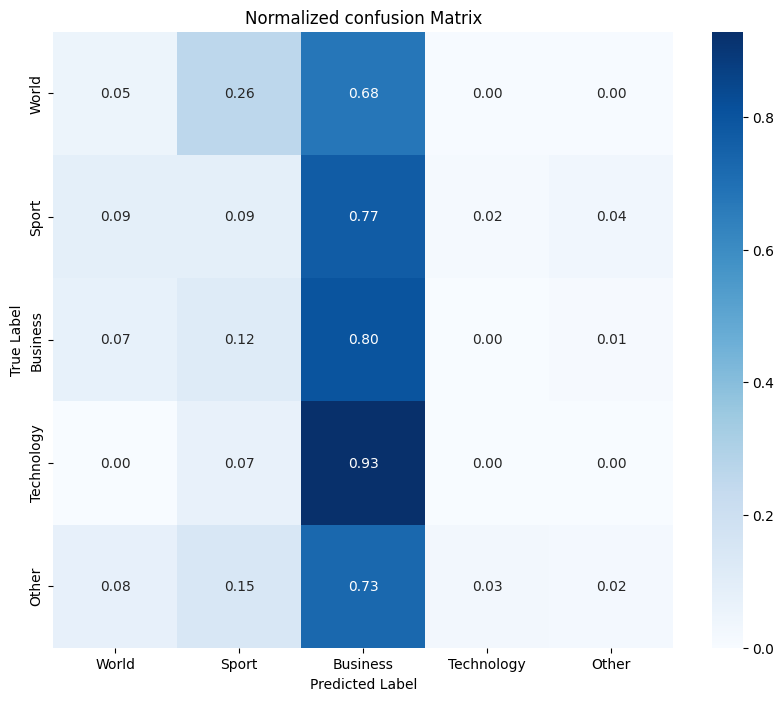

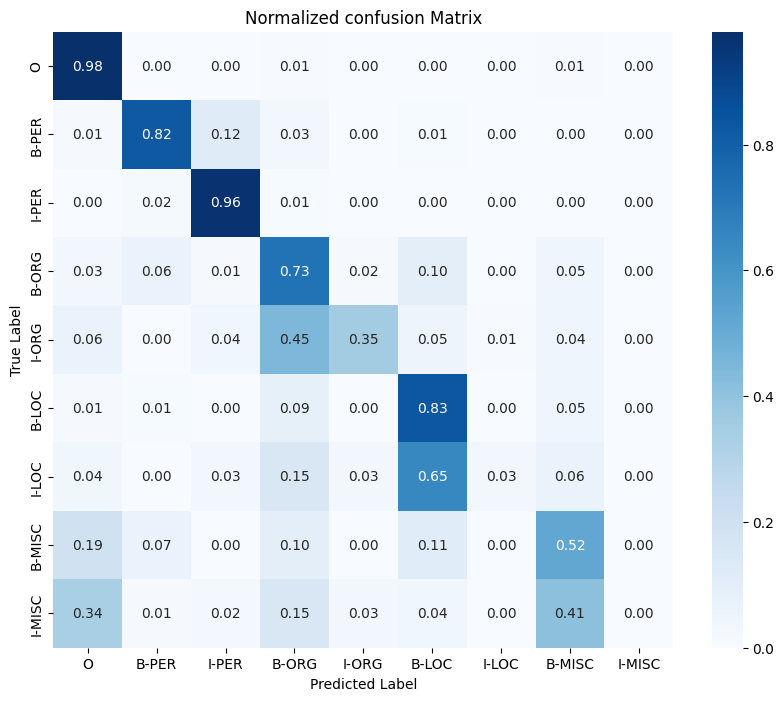

In [ ]:
class_names = [k for k, v in doc_label_dct.items()]
plot_confusion_matrix(eval_results['eval_doc_confusion_matrix'], class_names)

class_names = [k for k, v in ner_label_dct.items()]
plot_confusion_matrix(eval_results['eval_ner_confusion_matrix'], class_names)

In [ ]:
for key, value in eval_results.items():
  if key != 'eval_ner_confusion_matrix' and key != 'eval_doc_confusion_matrix':
    print(f"{key}: {value}")

eval_loss: 1.6473791599273682
eval_model_preparation_time: 0.0037
eval_ner_accuracy: 0.927076859332919
eval_ner_f1: 0.9241863220073996
eval_ner_precision: 0.9308875136611584
eval_ner_recall: 0.927076859332919
eval_doc_accuracy: 0.1500144801621778
eval_doc_f1: 0.09901524412523846
eval_doc_precision: 0.2664601756286111
eval_doc_recall: 0.1500144801621778
eval_f1: 0.5116007830663191
eval_runtime: 3381.6861
eval_samples_per_second: 1.021
eval_steps_per_second: 0.064
